In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Downloading  Data**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import seaborn as sns

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

import cv2
import torch
import torch.optim
from albumentations.pytorch import ToTensorV2
from torch import nn
from tqdm import tqdm

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sakshaymahna/cityscapes-depth-and-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cityscapes-depth-and-segmentation' dataset.
Path to dataset files: /kaggle/input/cityscapes-depth-and-segmentation


In [3]:
train_dir = os.path.join(path, 'data', 'train', 'image')
val_dir = os.path.join(path, 'data', 'val', 'image')

print(len(os.listdir(train_dir)), len(os.listdir(val_dir)))

2975 500


In [22]:
# import random

# images = os.listdir(train_dir)
# print(len(images))
# test_set = random.sample(images, 400)
# print(len(test_set))

# val_df = pd.DataFrame(data=[os.path.join(val_dir, os.listdir(val_dir)[i]) for i in range(len(os.listdir(val_dir)))], columns=['image_path'])
# test_df = pd.DataFrame(data=[os.path.join(train_dir, test_set[i]) for i in range(len(test_set))], columns=['image_path'])
# train_df = pd.DataFrame(data=[os.path.join(train_dir, images[i]) for i in range(len(images)) if images[i] not in test_set], columns=['image_path'])

# print(len(val_df), len(test_df), len(train_df))

2975
400
500 400 2575


In [ ]:
from google.colab import files
files.upload()

In [24]:
val_df = pd.read_csv('/content/val.csv')
test_df = pd.read_csv('/content/test.csv')
train_df = pd.read_csv('/content/train.csv')


In [45]:
train_df.head()

image_path
0    612.npy
1   1884.npy
2   1886.npy
3   2550.npy
4   2673.npy

In [27]:
val_df = pd.DataFrame(data=[os.path.join(val_dir, val_df['image_path'].values[i]) for i in range(len(val_df))], columns=['image_path'])
test_df = pd.DataFrame(data=[os.path.join(train_dir, test_df['image_path'].values[i]) for i in range(len(test_df))], columns=['image_path'])
train_df = pd.DataFrame(data=[os.path.join(train_dir, train_df['image_path'].values[i]) for i in range(len(train_df))], columns=['image_path'])

# **Check Data**

2594.npy
(128, 256, 3) (128, 256)


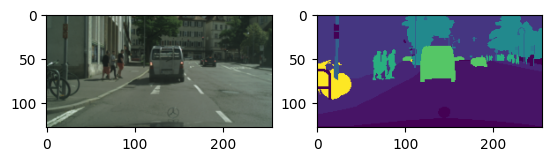

Unique images: [-1.  0.  1.  2.  5.  6.  7.  8.  9. 11. 13. 18.]
********************
966.npy
(128, 256, 3) (128, 256)


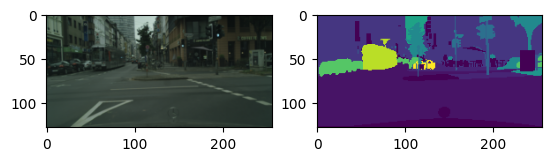

Unique images: [-1.  0.  1.  2.  4.  5.  6.  7.  8.  9. 10. 13. 16. 18.]
********************
2394.npy
(128, 256, 3) (128, 256)


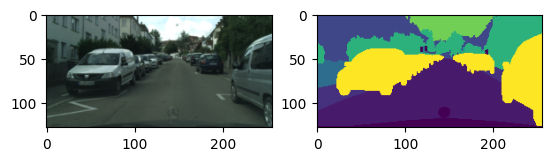

Unique images: [-1.  0.  1.  2.  4.  5.  7.  8. 10. 13.]
********************
2310.npy
(128, 256, 3) (128, 256)


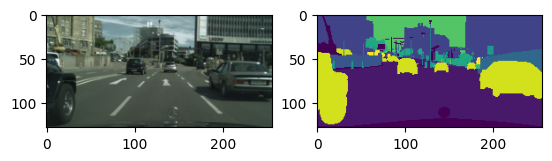

Unique images: [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 14.]
********************
1839.npy
(128, 256, 3) (128, 256)


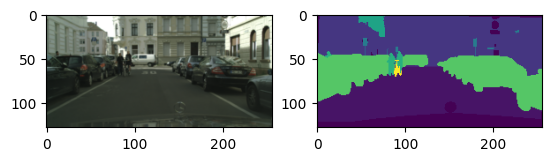

Unique images: [-1.  0.  1.  2.  5.  7. 10. 11. 13. 18.]
********************
438.npy
(128, 256, 3) (128, 256)


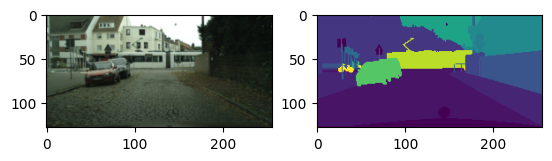

Unique images: [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 16. 18.]
********************
2662.npy
(128, 256, 3) (128, 256)


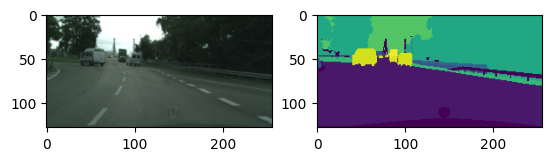

Unique images: [-1.  0.  3.  4.  5.  7.  8.  9. 10. 13. 14.]
********************
431.npy
(128, 256, 3) (128, 256)


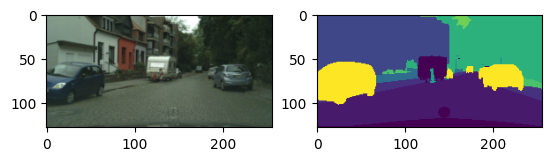

Unique images: [-1.  0.  1.  2.  4.  5.  7.  8.  9. 10. 13.]
********************
456.npy
(128, 256, 3) (128, 256)


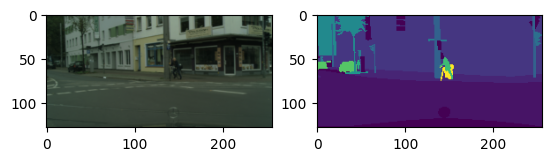

Unique images: [-1.  0.  1.  2.  5.  6.  7.  8.  9. 11. 12. 13. 18.]
********************
2949.npy
(128, 256, 3) (128, 256)


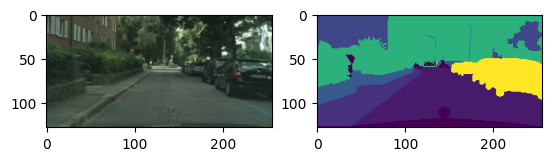

Unique images: [-1.  0.  1.  2.  3.  5.  7.  8.  9. 11. 13.]
********************


In [ ]:
# Visualize some samples
import random

sample = random.sample(list(train_df['image_path'].values), 10)

for image_path in sample:
    print(image_path.split('/')[-1])
    image = np.load(image_path)

    label_path = image_path.replace('image', 'label')
    label = np.load(label_path)
    print(image.shape, label.shape)

    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(label)
    plt.show()
    print(f'Unique images: {np.unique(label)}')
    print(20*'*')


# **Data Preparation**

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.

__getitem__ to support the indexing such that dataset[i] can be used to get
ith sample.

**Note about using to_categorical in this context:** <br>
the answer depends on the deep learning framework you're using and the specific loss function your model will employ.

**For PyTorch (Common Approach): No, you typically do NOT use to_categorical**
In PyTorch, for multi-class semantic segmentation, the most common approach is to use torch.nn.CrossEntropyLoss as your loss function. This loss function expects the target (your mask) to be integer class IDs (i.e., your single-channel (H, W) mask with pixel values from 0 to 7) and not one-hot encoded.

The model's output layer, in this case, would typically produce N channels (where N is the number of classes), representing the raw logits for each class at every pixel location. The CrossEntropyLoss function then internally applies a softmax to these logits and computes the loss against your integer-encoded target mask.

Example Flow with PyTorch's CrossEntropyLoss:

1. Input Image: (C, H, W) (e.g., (3, 256, 256))
2. Model Output (logits): (N_classes, H, W) (e.g., (7, 256, 256) where 7 is your number of classes)
3. Target Mask (your gray_mask): (H, W) with integer class IDs (e.g., (256, 256) with pixel values 0-6)
4. Loss Calculation: loss = torch.nn.CrossEntropyLoss()(model_output_logits, target_mask.long())
Therefore, your gray_mask (with integer class IDs) is in the perfect format for torch.nn.CrossEntropyLoss.

**When to_categorical (One-Hot Encoding) MIGHT be needed:**
* **Custom Loss Functions:** If you were implementing a custom loss function that explicitly requires one-hot encoded labels (e.g., some variations of Dice Loss or Focal Loss might expect this, though many have versions that can handle integer masks).
* **Keras/TensorFlow (if using CategoricalCrossentropy):** In TensorFlow/Keras, if you use tf.keras.losses.CategoricalCrossentropy, you would need to one-hot encode your labels. However, if you use tf.keras.losses.SparseCategoricalCrossentropy, you would not need to, as it expects integer class IDs, similar to PyTorch's CrossEntropyLoss.

**Why avoiding to_categorical is often better:**
* Memory Efficiency: One-hot encoding significantly increases the memory footprint of your labels. A (H, W) mask becomes an (N_classes, H, W) tensor. For large images and many classes, this can consume a lot of GPU memory.
* Computational Efficiency: It adds an extra computational step that CrossEntropyLoss handles internally more efficiently.
So, based on the standard practices for semantic segmentation in PyTorch, stick with your single-channel integer masks!

So, what about the ordinal relation between 0 - 7 labels?

Indeed, when we represent our 7 classes as integer IDs from 0 to 6 (or 0 to 7 as you have), those numbers are inherently ordinal. If these numbers were used in a context where their numerical value implies a relationship (e.g., if class 6 was 'twice as important' or 'further away' from class 0 than class 1), that would be a significant problem.

However, in the context of semantic segmentation with a loss function like PyTorch's CrossEntropyLoss (or TensorFlow's SparseCategoricalCrossentropy), these integer labels (0, 1, 2, ..., 7) are not treated as ordinal values with meaningful magnitudes by the loss function itself. Instead, they are interpreted purely as indices or identifiers for the classes.

Let me explain how this works to alleviate the concern about false ordinal relationships:

1. Model Output: Your segmentation model typically outputs a tensor of shape (N_classes, H, W) (e.g., (8, 2160, 3840) for 8 classes). For each pixel, this tensor contains 8 values (logits). Each logit corresponds to the model's unnormalized prediction for one of your classes (class 0, class 1, ..., class 7).

2. Target Mask: Your gray_mask has shape (H, W) (e.g., (2160, 3840)), where each pixel's value is an integer from 0 to 7.

3. Loss Calculation (CrossEntropyLoss): When CrossEntropyLoss computes the loss for a specific pixel, it does the following:

It takes the integer value from your gray_mask (e.g., if a pixel is labeled 6).
It uses this 6 as an index to select the corresponding logit from the model's output for that pixel (i.e., the logit for class 6).
It then calculates the cross-entropy loss by comparing this selected logit (and implicitly the probabilities for all classes) against a

In [6]:
def get_transforms(phase, height, width):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(height, width), # Correctly pass height and width
            ToTensorV2()
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [7]:
import cv2
import numpy as np
import os

from pathlib import Path


class Preprocessor():
    def __init__(self,
                 image_path: Path,
                 normalize_flag: bool = True,
                 mean: tuple =(0.485, 0.456, 0.406),
                 std: tuple =(0.229, 0.224, 0.225)):
        self.image_path = image_path
        self.normalize_flag = normalize_flag
        self.mean = mean
        self.std = std

    def preprocess_image(self):
        image = self._read_image(self.image_path)
        if self.normalize_flag:
            image = self._normalize(image)
        return image

    @staticmethod
    def _read_image(file_path):
        image = np.load(file_path)
        image = image.astype(float)
        return image

    def _normalize(self, image):
        """
        Standard normalization is applied using the formula:
        img = (img - mean * max_pixel_value) / (std * max_pixel_value).
        """
        mean = np.array(self.mean, dtype=np.float32)
        std = np.array(self.std, dtype=np.float32)
        image = (image - mean) / std
        # image = (image - mean * 255) / (std * 255)
        return image

In [8]:
from torch.utils.data import Dataset, DataLoader


labels_def = {0: 'Unlabeled', 1: 'road', 2: 'sidewalk', 3: 'building', 4: 'wall',
                5: 'fence', 6: 'pole', 7: 'traffic_light', 8: 'traffic_sign',
                9: 'vegetation', 10: 'terrain', 11: 'sky', 12: 'person', 13: 'rider',
                14: 'car', 15: 'truck', 16: 'bus', 17: 'train', 18: 'motorcycle', 19: 'bicycle'}
mapping_dict = {-1: 0,
                0: 0,
                1: 1,
                2: 1,  # sidewalk
                3: 2,  # building
                4: 2,  # wall
                5: 2,  # fence
                6: 0,  # pole
                7: 3,  # traffic_light
                8: 3,  # traffic_sign
                9: 4,  # vegetation
                10: 5,  # terrain
                11: 6,  # sky
                12: 7,  # person
                13: 7,  # rider
                14: 8,  # car
                15: 9,  # truck
                16: 9,  # bus
                17: 9,  # train
                18: 10,  # motorcycle
                19: 0,  # bicycle  It seems there are no bikes in this dataset
                }

def encode_labels(mask, mapping_dict):
    label_mask = np.zeros_like(mask)
    for k in mapping_dict.keys():
        label_mask[mask == k] = mapping_dict[k]
    return label_mask


class SemanticSegmentationDataset(Dataset):
    def __init__(self,
                 data_paths: Path,
                 phase: str,
                 height=128,
                 width=256,
                 mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225)):
        self.data_paths = data_paths
        self.transforms = get_transforms(phase, height, width,)
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.data_paths[idx]
        preprocessor = Preprocessor(image_path=image_path,
                                    mean=self.mean,
                                    std=self.std)
        image = preprocessor.preprocess_image()
        # mask = preprocessor.preprocess_mask()
        mask = np.load(image_path.replace('image', 'label'))

        # Removed: mask = mask.astype(float) to keep mask as integer type
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask'] # This mask is now a float32 tensor from ToTensorV2
        # Apply remapping after augmentations and ToTensorV2
        mask = encode_labels(mask, mapping_dict)
        mask = torch.Tensor(mask).long() # Explicitly convert mask to LongTensor for CrossEntropyLoss

        return image, mask


class DataGenerator:
    def __init__(self,
                 df: pd.DataFrame,
                 phase: str,
                 batch_size: int,
                 shuffle: bool):
        self.df = df
        self.phase = phase
        self.batch_size = batch_size
        self.shuffle = shuffle

    def load_data(self):
        paths = self.df['image_path'].values.tolist()
        dataset = SemanticSegmentationDataset(paths, phase=self.phase)
        dataloader = DataLoader(dataset,
                                batch_size=self.batch_size,
                                shuffle=self.shuffle,
                                num_workers=os.cpu_count())
        return dataloader

In [28]:
data_generator = DataGenerator(train_df, "train", 16, True).load_data()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [29]:
print(len(data_generator))
# Define mean and std tensors matching those used in get_transforms
# Assuming these are the values used for normalization in get_transforms
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

for batch in data_generator:
    image, mask = batch
    print('data loader shapes: \n')
    print(image.shape)
    print(mask.shape)
    print(image[0].shape)
    print(image[0].dtype)
    print(np.unique(mask))
    print(image.mean(), image.min(), image.max())
    break

161
data loader shapes: 

torch.Size([16, 3, 128, 256])
torch.Size([16, 128, 256])
torch.Size([3, 128, 256])
torch.float64
[ 0  1  2  3  4  5  6  7  8  9 10]
tensor(-0.6672, dtype=torch.float64) tensor(-2.1008, dtype=torch.float64) tensor(2.6400, dtype=torch.float64)


67.80731201171875 16 255
[ 0  1  2  3  4  5  6  7 10]


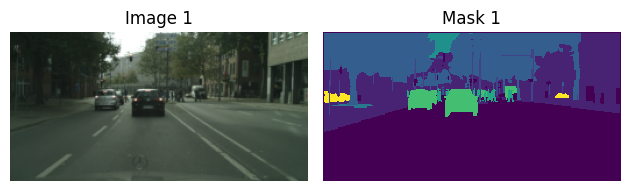

74.81619262695312 14 255
[ 0  1  2  3  4  5  6  7  9 10]


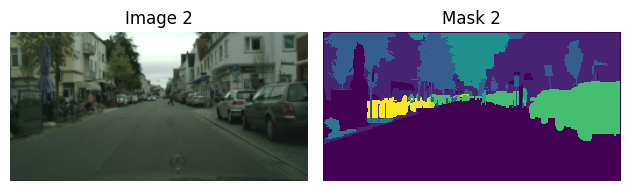

84.37484741210938 4 255
[ 0  1  2  3  4  5  6  7 10]


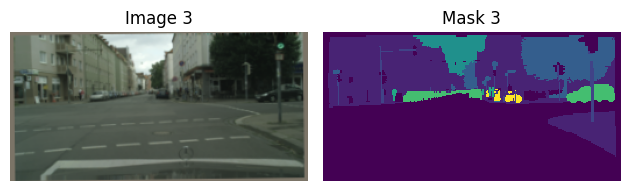

69.93495686848958 11 255
[0 1 2 3 4 5 6 7 9]


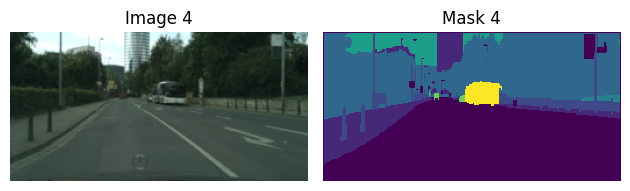

In [30]:
for k in range(4):
        img_to_show_normalized = image[k].cpu() # Get a single image tensor and move to CPU

        # Denormalize the image tensor (reverse the normalization step)
        # NORM_MEAN and NORM_STD should be reshaped to (3, 1, 1) for broadcasting across channels
        img_to_show_denormalized = img_to_show_normalized * NORM_STD.view(3, 1, 1) + NORM_MEAN.view(3, 1, 1)

        # Clamp values to [0, 1] range to ensure valid display by matplotlib
        img_to_show_clamped = torch.clamp(img_to_show_denormalized, 0, 1)

        # Permute from (C, H, W) to (H, W, C) for matplotlib and convert to numpy
        # Optionally scale to [0, 255] and cast to uint8 for typical image viewing
        img_to_show_np = (img_to_show_clamped.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        print(img_to_show_np.mean(), img_to_show_np.min(), img_to_show_np.max())

        plt.subplot(121)
        plt.imshow(img_to_show_np)
        plt.title(f"Image {k+1}")
        plt.axis('off')

        # Process mask for display
        mask_to_show_np = mask[k].cpu().numpy() # Move to CPU and convert to numpy
        print(np.unique(mask_to_show_np))
        plt.subplot(122)
        # Use a colormap for masks to differentiate classes, and 'nearest' interpolation
        plt.imshow(mask_to_show_np, cmap='viridis', interpolation='nearest')
        plt.title(f"Mask {k+1}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# **EDA & Checking Class Distributions**

In [ ]:
mapping_dict = {-1: 0,
                0: 0,
                1: 1,
                2: 1,  # sidewalk
                3: 2,  # building
                4: 2,  # wall
                5: 2,  # fence
                6: 0,  # pole
                7: 3,  # traffic_light
                8: 3,  # traffic_sign
                9: 4,  # vegetation
                10: 5,  # terrain
                11: 6,  # sky
                12: 7,  # person
                13: 7,  # rider
                14: 8,  # car
                15: 9,  # truck
                16: 9,  # bus
                17: 9,  # train
                18: 10,  # motorcycle
                19: 0,  # bicycle
                }

In [39]:
# clss dists

def count_labels(masks):
  labels_def = {0: 'background', 1: 'road', 2: 'structure', 3: 'traffic_sign', 4: 'vegetation',
                5: 'terrain', 6: 'sky', 7: 'person', 8: 'car',
                9: 'large_vehicle', 10: 'motorcycle'}

  counter_dict = {k: 0 for k in labels_def.values()}
  pxs = []
  for mask in tqdm(masks):
      for px in mask.flatten():
        counter_dict[labels_def[px.item()]] += 1
  pxs_num = mask.shape[0] * mask.shape[1]
  counter_dict_perc = {k: (100 * v / (len(masks) * pxs_num)) for k, v in counter_dict.items()}

  return counter_dict_perc



In [40]:
train_generator = DataGenerator(train_df, "train", len(train_df), True).load_data()
val_generator = DataGenerator(val_df, "val", len(val_df), False).load_data()
test_generator = DataGenerator(test_df, "test", len(test_df), False).load_data()

In [41]:
train_masks = next(iter(train_generator))[1]
val_masks = next(iter(val_generator))[1]
test_masks = next(iter(test_generator))[1]

In [42]:
train_labels = count_labels(train_masks)
val_labels = count_labels(val_masks)
test_labels = count_labels(test_masks)

sum(test_labels.values()), sum(train_labels.values()), sum(val_labels.values())

100%|██████████| 400/400 [00:28<00:00, 13.96it/s]


(100.0, 100.0, 100.0)

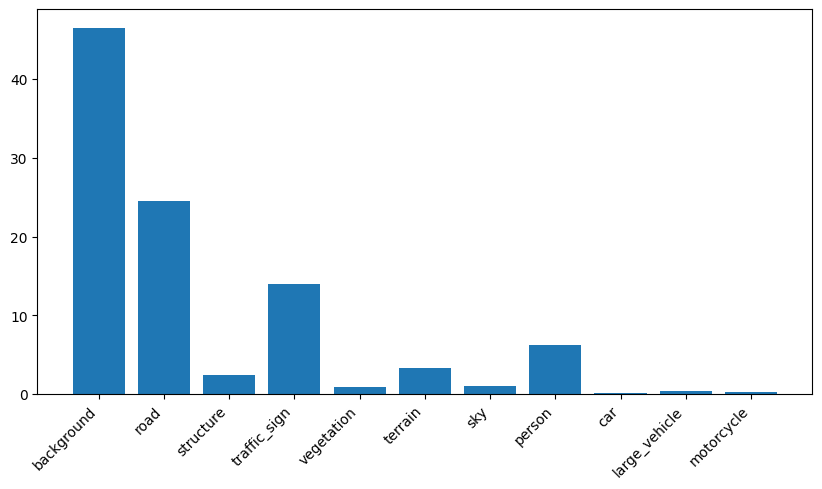

In [43]:
plt.figure(figsize=(10, 5))
plt.bar(train_labels.keys(), train_labels.values(), label='train')
plt.xticks(rotation=45, ha='right')
plt.show()

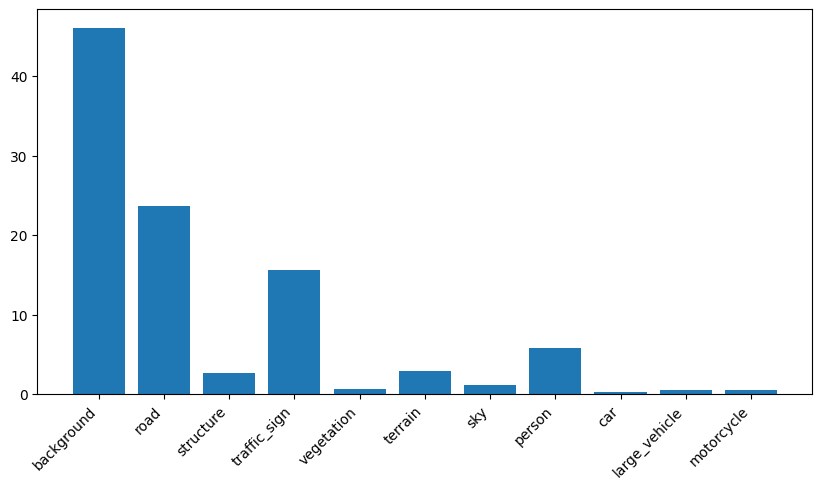

In [44]:
plt.figure(figsize=(10, 5))
plt.bar(val_labels.keys(), val_labels.values(), label='validation')
plt.xticks(rotation=45, ha='right')
plt.show()

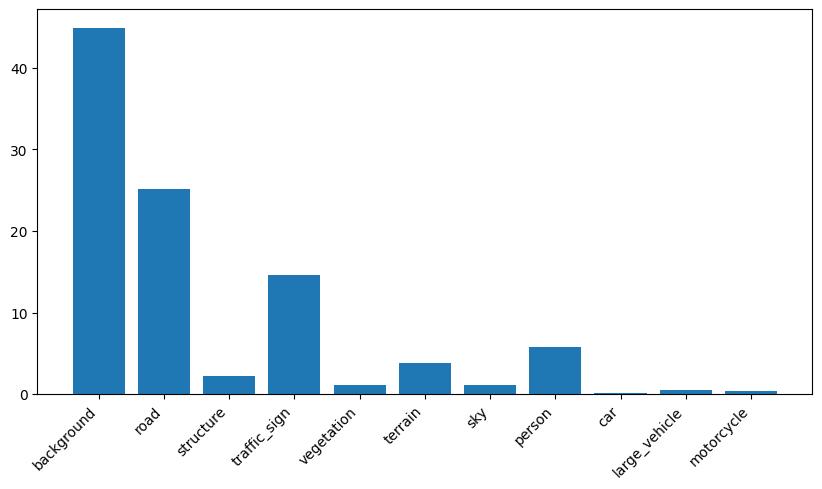

In [45]:
plt.figure(figsize=(10, 5))
plt.bar(test_labels.keys(), test_labels.values(), label='test')
plt.xticks(rotation=45, ha='right')
plt.show()

In [46]:
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)


We have performed the normalization process in the Preprocessor class. If you want, you can do it using albumentation as follows. The result will be the same.

In [ ]:
# def get_transforms(phase, height, width, mean, std):
#     list_transforms = []
#     if phase == "train":
#         list_transforms.extend(
#             [
#                 HorizontalFlip(),
#                 ShiftScaleRotate(
#                     shift_limit=0,  # no resizing
#                     scale_limit=0.1,
#                     rotate_limit=10, # rotate
#                     p=0.5,
#                     border_mode=cv2.BORDER_CONSTANT
#                 ),
# #                 GaussNoise(),
#             ]
#         )
#     list_transforms.extend(
#         [
#             Normalize(mean=mean, std=std),
#             Resize(height, width), # Correctly pass height and width
#             ToTensorV2()
#         ]
#     )
#     list_trfms = Compose(list_transforms)
#     return list_trfms

In [32]:
train_generator = DataGenerator(train_df, phase="train", batch_size=16, shuffle=True).load_data()
val_generator = DataGenerator(val_df, phase="val", batch_size=len(val_df), shuffle=False).load_data()
test_generator = DataGenerator(test_df, phase="test", batch_size=len(test_df), shuffle=False).load_data()

# Model Building

In [ ]:
# !git clone https://github.com/qubvel-org/segmentation_models.pytorch.git

In [33]:
!pip install segmentation_models_pytorch > /dev/null -q

In [34]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [35]:
# Some training hyperparameters
EPOCHS = 80
T_MAX = EPOCHS * len(train_generator)
# Always include the background as a class
OUT_CLASSES = 11

In [41]:
import segmentation_models_pytorch as smp

activation = 'sigmoid' if OUT_CLASSES == 1 else 'softmax'
model = smp.Unet(
    encoder_name="efficientnet-b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,                     # model output classes (number of classes in your dataset)
    activation=activation
).to(device)


print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Ident

# Training

## Loss and Optimizer
- Loss = BCE + Dice_loss
- Optimizer = Adam with initial_lr = 1e-3
- lr_scheduler with CosineAnnealingLR for lr decay

In [42]:
# Loss function for multi-class segmentation
# loss_function = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
loss_function = smp.losses.FocalLoss(mode='multiclass')

optimizer = torch.optim.Adam(model.parameters(), 1e-3,weight_decay=0)

epoch_num = 80
val_interval = 1

steps = epoch_num  #int(len(train_slices)/batch_size)+1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

## Training

In [43]:
import sys
from tqdm import tqdm


best_metric = -1 # Initialize with a value that will be easily surpassed
best_metric_epoch = -1
epoch_loss_values = []
metric_values = [] # This will store average IoU for each epoch

for epoch in tqdm(range(epoch_num)):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    epoch_len = len(train_generator)
    step = 0
    for i_batch, batch_data in enumerate(train_generator):

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        inputs = inputs.float() # Convert input to float32
        optimizer.zero_grad()
        outputs = model(inputs) # Logits (Batch, Classes, H, W)
        loss = loss_function(outputs, labels) # CrossEntropyLoss expects logits and Long labels
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_iou_scores = []
            for val_data_batch in val_generator:
                val_images, val_labels = val_data_batch[0].to(device), val_data_batch[1].to(device)
                val_images = val_images.float() # Convert validation input to float32
                val_outputs = model(val_images) # Logits (Batch, Classes, H, W)

                # Convert logits to predicted class labels
                pr_masks = val_outputs.softmax(dim=1).argmax(dim=1)  # Shape: [batch_size, H, W]

                # Calculate TP, FP, FN, TN for multiclass
                # The `get_stats` function computes a confusion matrix for each image/batch
                # and returns summed tp, fp, fn, tn.
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pr_masks,  # Predicted mask (argmaxed)
                    val_labels, # Ground truth mask
                    mode='multiclass',
                    num_classes=OUT_CLASSES, # Number of classes (including background)
                    ignore_index=None, # Set an index if you want to ignore a specific class
                )

                # Calculate IoU score from the stats
                # The `reduction` parameter applies to how the IoU is averaged across classes and/or images.
                # 'micro' means sum TP, FP, FN across classes and then calculate IoU.
                batch_iou = smp.metrics.iou_score(
                    tp, fp, fn, tn,
                    reduction='macro'
                )
                val_iou_scores.append(batch_iou.item())

            avg_val_iou = np.mean(val_iou_scores)
            metric_values.append(avg_val_iou) # Store the average IoU for this epoch

            if avg_val_iou > best_metric:
                best_metric = avg_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f'best_model_epoch{epoch}_{avg_val_iou:.4f}.pth')
                print('###### Congratulations ###### saved new best metric model')
            scheduler.step()
            print(f"current epoch: {epoch + 1} current IoU: {avg_val_iou:.4f}"
                  f" best IoU: {best_metric:.4f} at epoch: {best_metric_epoch}")
        # scheduler.step()
        # Use get_last_lr() for PyTorch 1.4+ and later versions
        print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        print('The learning rate updated to :',scheduler.get_last_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

  0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80


  1%|▏         | 1/80 [00:40<53:32, 40.66s/it]

###### Congratulations ###### saved new best metric model
current epoch: 1 current IoU: 0.3300 best IoU: 0.3300 at epoch: 1

 ###### epoch 1 average loss: 1.8931
The learning rate updated to : 0.0009996145181203615
----------
epoch 2/80


  2%|▎         | 2/80 [01:19<51:48, 39.85s/it]

###### Congratulations ###### saved new best metric model
current epoch: 2 current IoU: 0.3404 best IoU: 0.3404 at epoch: 2

 ###### epoch 2 average loss: 1.8454
The learning rate updated to : 0.000998458666866564
----------
epoch 3/80


  4%|▍         | 3/80 [01:59<50:58, 39.72s/it]

###### Congratulations ###### saved new best metric model
current epoch: 3 current IoU: 0.3687 best IoU: 0.3687 at epoch: 3

 ###### epoch 3 average loss: 1.8392
The learning rate updated to : 0.0009965342284774632
----------
epoch 4/80


  5%|▌         | 4/80 [02:38<50:06, 39.56s/it]

###### Congratulations ###### saved new best metric model
current epoch: 4 current IoU: 0.4046 best IoU: 0.4046 at epoch: 4

 ###### epoch 4 average loss: 1.8348
The learning rate updated to : 0.0009938441702975688
----------
epoch 5/80


  6%|▋         | 5/80 [03:18<49:30, 39.61s/it]

###### Congratulations ###### saved new best metric model
current epoch: 5 current IoU: 0.4366 best IoU: 0.4366 at epoch: 5

 ###### epoch 5 average loss: 1.8313
The learning rate updated to : 0.0009903926402016151
----------
epoch 6/80


  8%|▊         | 6/80 [03:58<48:58, 39.71s/it]

###### Congratulations ###### saved new best metric model
current epoch: 6 current IoU: 0.4474 best IoU: 0.4474 at epoch: 6

 ###### epoch 6 average loss: 1.8276
The learning rate updated to : 0.0009861849601988382
----------
epoch 7/80


  9%|▉         | 7/80 [04:37<48:13, 39.63s/it]

###### Congratulations ###### saved new best metric model
current epoch: 7 current IoU: 0.4474 best IoU: 0.4474 at epoch: 7

 ###### epoch 7 average loss: 1.8250
The learning rate updated to : 0.0009812276182268236
----------
epoch 8/80


 10%|█         | 8/80 [05:17<47:27, 39.54s/it]

###### Congratulations ###### saved new best metric model
current epoch: 8 current IoU: 0.4533 best IoU: 0.4533 at epoch: 8

 ###### epoch 8 average loss: 1.8233
The learning rate updated to : 0.0009755282581475768
----------
epoch 9/80


 11%|█▏        | 9/80 [05:56<46:50, 39.58s/it]

###### Congratulations ###### saved new best metric model
current epoch: 9 current IoU: 0.4534 best IoU: 0.4534 at epoch: 9

 ###### epoch 9 average loss: 1.8214
The learning rate updated to : 0.0009690956679612421
----------
epoch 10/80


 12%|█▎        | 10/80 [06:36<46:12, 39.60s/it]

###### Congratulations ###### saved new best metric model
current epoch: 10 current IoU: 0.4607 best IoU: 0.4607 at epoch: 10

 ###### epoch 10 average loss: 1.8209
The learning rate updated to : 0.0009619397662556433
----------
epoch 11/80


 14%|█▍        | 11/80 [07:15<45:26, 39.52s/it]

current epoch: 11 current IoU: 0.4557 best IoU: 0.4607 at epoch: 10

 ###### epoch 11 average loss: 1.8186
The learning rate updated to : 0.0009540715869125406
----------
epoch 12/80


 15%|█▌        | 12/80 [07:55<44:44, 39.49s/it]

###### Congratulations ###### saved new best metric model
current epoch: 12 current IoU: 0.4625 best IoU: 0.4625 at epoch: 12

 ###### epoch 12 average loss: 1.8177
The learning rate updated to : 0.0009455032620941839
----------
epoch 13/80


 16%|█▋        | 13/80 [08:34<43:54, 39.32s/it]

###### Congratulations ###### saved new best metric model
current epoch: 13 current IoU: 0.4740 best IoU: 0.4740 at epoch: 13

 ###### epoch 13 average loss: 1.8170
The learning rate updated to : 0.0009362480035363986
----------
epoch 14/80


 18%|█▊        | 14/80 [09:13<43:19, 39.38s/it]

###### Congratulations ###### saved new best metric model
current epoch: 14 current IoU: 0.4747 best IoU: 0.4747 at epoch: 14

 ###### epoch 14 average loss: 1.8157
The learning rate updated to : 0.0009263200821770461
----------
epoch 15/80


 19%|█▉        | 15/80 [09:53<42:52, 39.57s/it]

###### Congratulations ###### saved new best metric model
current epoch: 15 current IoU: 0.4806 best IoU: 0.4806 at epoch: 15

 ###### epoch 15 average loss: 1.8151
The learning rate updated to : 0.0009157348061512728
----------
epoch 16/80


 20%|██        | 16/80 [10:32<42:05, 39.46s/it]

current epoch: 16 current IoU: 0.4761 best IoU: 0.4806 at epoch: 15

 ###### epoch 16 average loss: 1.8140
The learning rate updated to : 0.0009045084971874739
----------
epoch 17/80


 21%|██▏       | 17/80 [11:12<41:24, 39.44s/it]

current epoch: 17 current IoU: 0.4782 best IoU: 0.4806 at epoch: 15

 ###### epoch 17 average loss: 1.8127
The learning rate updated to : 0.0008926584654403725
----------
epoch 18/80


 22%|██▎       | 18/80 [11:52<40:49, 39.51s/it]

current epoch: 18 current IoU: 0.4776 best IoU: 0.4806 at epoch: 15

 ###### epoch 18 average loss: 1.8129
The learning rate updated to : 0.0008802029828000156
----------
epoch 19/80


 24%|██▍       | 19/80 [12:31<40:11, 39.53s/it]

###### Congratulations ###### saved new best metric model
current epoch: 19 current IoU: 0.5009 best IoU: 0.5009 at epoch: 19

 ###### epoch 19 average loss: 1.8111
The learning rate updated to : 0.0008671612547178428
----------
epoch 20/80


 25%|██▌       | 20/80 [13:11<39:29, 39.50s/it]

###### Congratulations ###### saved new best metric model
current epoch: 20 current IoU: 0.5045 best IoU: 0.5045 at epoch: 20

 ###### epoch 20 average loss: 1.8111
The learning rate updated to : 0.0008535533905932737
----------
epoch 21/80


 26%|██▋       | 21/80 [13:50<38:45, 39.41s/it]

current epoch: 21 current IoU: 0.5044 best IoU: 0.5045 at epoch: 20

 ###### epoch 21 average loss: 1.8097
The learning rate updated to : 0.0008394003727664709
----------
epoch 22/80


 28%|██▊       | 22/80 [14:29<38:02, 39.36s/it]

###### Congratulations ###### saved new best metric model
current epoch: 22 current IoU: 0.5066 best IoU: 0.5066 at epoch: 22

 ###### epoch 22 average loss: 1.8095
The learning rate updated to : 0.0008247240241650919
----------
epoch 23/80


 29%|██▉       | 23/80 [15:09<37:27, 39.43s/it]

###### Congratulations ###### saved new best metric model
current epoch: 23 current IoU: 0.5139 best IoU: 0.5139 at epoch: 23

 ###### epoch 23 average loss: 1.8088
The learning rate updated to : 0.000809546974654917
----------
epoch 24/80


 30%|███       | 24/80 [15:48<36:54, 39.54s/it]

current epoch: 24 current IoU: 0.5138 best IoU: 0.5139 at epoch: 23

 ###### epoch 24 average loss: 1.8079
The learning rate updated to : 0.0007938926261462366
----------
epoch 25/80


 31%|███▏      | 25/80 [16:28<36:12, 39.50s/it]

###### Congratulations ###### saved new best metric model
current epoch: 25 current IoU: 0.5162 best IoU: 0.5162 at epoch: 25

 ###### epoch 25 average loss: 1.8069
The learning rate updated to : 0.0007777851165098012
----------
epoch 26/80


 32%|███▎      | 26/80 [17:07<35:29, 39.44s/it]

###### Congratulations ###### saved new best metric model
current epoch: 26 current IoU: 0.5277 best IoU: 0.5277 at epoch: 26

 ###### epoch 26 average loss: 1.8065
The learning rate updated to : 0.0007612492823579744
----------
epoch 27/80


 34%|███▍      | 27/80 [17:47<34:58, 39.59s/it]

###### Congratulations ###### saved new best metric model
current epoch: 27 current IoU: 0.5525 best IoU: 0.5525 at epoch: 27

 ###### epoch 27 average loss: 1.8060
The learning rate updated to : 0.0007443106207484776
----------
epoch 28/80


 35%|███▌      | 28/80 [18:27<34:21, 39.65s/it]

###### Congratulations ###### saved new best metric model
current epoch: 28 current IoU: 0.5534 best IoU: 0.5534 at epoch: 28

 ###### epoch 28 average loss: 1.8046
The learning rate updated to : 0.0007269952498697734
----------
epoch 29/80


 36%|███▋      | 29/80 [19:06<33:40, 39.62s/it]

###### Congratulations ###### saved new best metric model
current epoch: 29 current IoU: 0.5540 best IoU: 0.5540 at epoch: 29

 ###### epoch 29 average loss: 1.8041
The learning rate updated to : 0.0007093298687687142
----------
epoch 30/80


 38%|███▊      | 30/80 [19:46<32:58, 39.58s/it]

###### Congratulations ###### saved new best metric model
current epoch: 30 current IoU: 0.5589 best IoU: 0.5589 at epoch: 30

 ###### epoch 30 average loss: 1.8043
The learning rate updated to : 0.000691341716182545
----------
epoch 31/80


 39%|███▉      | 31/80 [20:26<32:21, 39.62s/it]

###### Congratulations ###### saved new best metric model
current epoch: 31 current IoU: 0.5593 best IoU: 0.5593 at epoch: 31

 ###### epoch 31 average loss: 1.8035
The learning rate updated to : 0.0006730585285387465
----------
epoch 32/80


 40%|████      | 32/80 [21:05<31:45, 39.69s/it]

current epoch: 32 current IoU: 0.5574 best IoU: 0.5593 at epoch: 31

 ###### epoch 32 average loss: 1.8028
The learning rate updated to : 0.0006545084971874737
----------
epoch 33/80


 41%|████▏     | 33/80 [21:46<31:12, 39.83s/it]

###### Congratulations ###### saved new best metric model
current epoch: 33 current IoU: 0.5630 best IoU: 0.5630 at epoch: 33

 ###### epoch 33 average loss: 1.8022
The learning rate updated to : 0.0006357202249325371
----------
epoch 34/80


 42%|████▎     | 34/80 [22:25<30:31, 39.82s/it]

###### Congratulations ###### saved new best metric model
current epoch: 34 current IoU: 0.5685 best IoU: 0.5685 at epoch: 34

 ###### epoch 34 average loss: 1.8016
The learning rate updated to : 0.0006167226819279528
----------
epoch 35/80


 44%|████▍     | 35/80 [23:06<29:58, 39.96s/it]

###### Congratulations ###### saved new best metric model
current epoch: 35 current IoU: 0.5709 best IoU: 0.5709 at epoch: 35

 ###### epoch 35 average loss: 1.8012
The learning rate updated to : 0.0005975451610080642
----------
epoch 36/80


 45%|████▌     | 36/80 [23:45<29:12, 39.83s/it]

current epoch: 36 current IoU: 0.5667 best IoU: 0.5709 at epoch: 35

 ###### epoch 36 average loss: 1.8010
The learning rate updated to : 0.0005782172325201155
----------
epoch 37/80


 46%|████▋     | 37/80 [24:26<28:40, 40.02s/it]

current epoch: 37 current IoU: 0.5704 best IoU: 0.5709 at epoch: 35

 ###### epoch 37 average loss: 1.8000
The learning rate updated to : 0.0005587686987289189
----------
epoch 38/80


 48%|████▊     | 38/80 [25:05<27:55, 39.90s/it]

###### Congratulations ###### saved new best metric model
current epoch: 38 current IoU: 0.5715 best IoU: 0.5715 at epoch: 38

 ###### epoch 38 average loss: 1.8002
The learning rate updated to : 0.0005392295478639225
----------
epoch 39/80


 49%|████▉     | 39/80 [25:45<27:11, 39.79s/it]

###### Congratulations ###### saved new best metric model
current epoch: 39 current IoU: 0.5722 best IoU: 0.5722 at epoch: 39

 ###### epoch 39 average loss: 1.8000
The learning rate updated to : 0.0005196299078795343
----------
epoch 40/80


 50%|█████     | 40/80 [26:24<26:30, 39.76s/it]

current epoch: 40 current IoU: 0.5688 best IoU: 0.5722 at epoch: 39

 ###### epoch 40 average loss: 1.7990
The learning rate updated to : 0.0005
----------
epoch 41/80


 51%|█████▏    | 41/80 [27:05<25:54, 39.85s/it]

###### Congratulations ###### saved new best metric model
current epoch: 41 current IoU: 0.5771 best IoU: 0.5771 at epoch: 41

 ###### epoch 41 average loss: 1.7988
The learning rate updated to : 0.00048037009212046586
----------
epoch 42/80


 52%|█████▎    | 42/80 [27:44<25:08, 39.71s/it]

current epoch: 42 current IoU: 0.5729 best IoU: 0.5771 at epoch: 41

 ###### epoch 42 average loss: 1.7985
The learning rate updated to : 0.00046077045213607765
----------
epoch 43/80


 54%|█████▍    | 43/80 [28:23<24:27, 39.66s/it]

current epoch: 43 current IoU: 0.5751 best IoU: 0.5771 at epoch: 41

 ###### epoch 43 average loss: 1.7982
The learning rate updated to : 0.0004412313012710813
----------
epoch 44/80


 55%|█████▌    | 44/80 [29:03<23:44, 39.58s/it]

current epoch: 44 current IoU: 0.5758 best IoU: 0.5771 at epoch: 41

 ###### epoch 44 average loss: 1.7976
The learning rate updated to : 0.00042178276747988476
----------
epoch 45/80


 56%|█████▋    | 45/80 [29:43<23:05, 39.60s/it]

current epoch: 45 current IoU: 0.5746 best IoU: 0.5771 at epoch: 41

 ###### epoch 45 average loss: 1.7974
The learning rate updated to : 0.000402454838991936
----------
epoch 46/80


 57%|█████▊    | 46/80 [30:23<22:32, 39.77s/it]

current epoch: 46 current IoU: 0.5750 best IoU: 0.5771 at epoch: 41

 ###### epoch 46 average loss: 1.7971
The learning rate updated to : 0.00038327731807204744
----------
epoch 47/80


 59%|█████▉    | 47/80 [31:02<21:52, 39.76s/it]

###### Congratulations ###### saved new best metric model
current epoch: 47 current IoU: 0.5795 best IoU: 0.5795 at epoch: 47

 ###### epoch 47 average loss: 1.7967
The learning rate updated to : 0.00036427977506746286
----------
epoch 48/80


 60%|██████    | 48/80 [31:42<21:08, 39.64s/it]

current epoch: 48 current IoU: 0.5751 best IoU: 0.5795 at epoch: 47

 ###### epoch 48 average loss: 1.7965
The learning rate updated to : 0.00034549150281252644
----------
epoch 49/80


 61%|██████▏   | 49/80 [32:22<20:30, 39.71s/it]

###### Congratulations ###### saved new best metric model
current epoch: 49 current IoU: 0.5808 best IoU: 0.5808 at epoch: 49

 ###### epoch 49 average loss: 1.7964
The learning rate updated to : 0.00032694147146125374
----------
epoch 50/80


 62%|██████▎   | 50/80 [33:01<19:49, 39.65s/it]

###### Congratulations ###### saved new best metric model
current epoch: 50 current IoU: 0.5808 best IoU: 0.5808 at epoch: 50

 ###### epoch 50 average loss: 1.7961
The learning rate updated to : 0.0003086582838174553
----------
epoch 51/80


 64%|██████▍   | 51/80 [33:41<19:09, 39.65s/it]

###### Congratulations ###### saved new best metric model
current epoch: 51 current IoU: 0.5848 best IoU: 0.5848 at epoch: 51

 ###### epoch 51 average loss: 1.7955
The learning rate updated to : 0.00029067013123128623
----------
epoch 52/80


 65%|██████▌   | 52/80 [34:21<18:30, 39.67s/it]

###### Congratulations ###### saved new best metric model
current epoch: 52 current IoU: 0.5936 best IoU: 0.5936 at epoch: 52

 ###### epoch 52 average loss: 1.7953
The learning rate updated to : 0.0002730047501302268
----------
epoch 53/80


 66%|██████▋   | 53/80 [35:00<17:52, 39.73s/it]

###### Congratulations ###### saved new best metric model
current epoch: 53 current IoU: 0.5996 best IoU: 0.5996 at epoch: 53

 ###### epoch 53 average loss: 1.7950
The learning rate updated to : 0.0002556893792515226
----------
epoch 54/80


 68%|██████▊   | 54/80 [35:41<17:16, 39.86s/it]

current epoch: 54 current IoU: 0.5965 best IoU: 0.5996 at epoch: 53

 ###### epoch 54 average loss: 1.7947
The learning rate updated to : 0.00023875071764202575
----------
epoch 55/80


 69%|██████▉   | 55/80 [36:20<16:36, 39.88s/it]

###### Congratulations ###### saved new best metric model
current epoch: 55 current IoU: 0.6053 best IoU: 0.6053 at epoch: 55

 ###### epoch 55 average loss: 1.7943
The learning rate updated to : 0.000222214883490199
----------
epoch 56/80


 70%|███████   | 56/80 [37:00<15:55, 39.79s/it]

###### Congratulations ###### saved new best metric model
current epoch: 56 current IoU: 0.6088 best IoU: 0.6088 at epoch: 56

 ###### epoch 56 average loss: 1.7940
The learning rate updated to : 0.00020610737385376362
----------
epoch 57/80


 71%|███████▏  | 57/80 [37:40<15:14, 39.75s/it]

current epoch: 57 current IoU: 0.6021 best IoU: 0.6088 at epoch: 56

 ###### epoch 57 average loss: 1.7940
The learning rate updated to : 0.00019045302534508325
----------
epoch 58/80


 72%|███████▎  | 58/80 [38:20<14:39, 39.98s/it]

###### Congratulations ###### saved new best metric model
current epoch: 58 current IoU: 0.6113 best IoU: 0.6113 at epoch: 58

 ###### epoch 58 average loss: 1.7935
The learning rate updated to : 0.00017527597583490834
----------
epoch 59/80


 74%|███████▍  | 59/80 [39:00<13:56, 39.84s/it]

current epoch: 59 current IoU: 0.6050 best IoU: 0.6113 at epoch: 58

 ###### epoch 59 average loss: 1.7935
The learning rate updated to : 0.00016059962723352931
----------
epoch 60/80


 75%|███████▌  | 60/80 [39:39<13:14, 39.73s/it]

current epoch: 60 current IoU: 0.6085 best IoU: 0.6113 at epoch: 58

 ###### epoch 60 average loss: 1.7932
The learning rate updated to : 0.00014644660940672636
----------
epoch 61/80


 76%|███████▋  | 61/80 [40:19<12:35, 39.76s/it]

current epoch: 61 current IoU: 0.6092 best IoU: 0.6113 at epoch: 58

 ###### epoch 61 average loss: 1.7930
The learning rate updated to : 0.00013283874528215725
----------
epoch 62/80


 78%|███████▊  | 62/80 [40:59<11:58, 39.92s/it]

current epoch: 62 current IoU: 0.6092 best IoU: 0.6113 at epoch: 58

 ###### epoch 62 average loss: 1.7929
The learning rate updated to : 0.0001197970171999846
----------
epoch 63/80


 79%|███████▉  | 63/80 [41:39<11:16, 39.79s/it]

current epoch: 63 current IoU: 0.6077 best IoU: 0.6113 at epoch: 58

 ###### epoch 63 average loss: 1.7927
The learning rate updated to : 0.00010734153455962753
----------
epoch 64/80


 80%|████████  | 64/80 [42:19<10:38, 39.89s/it]

current epoch: 64 current IoU: 0.6110 best IoU: 0.6113 at epoch: 58

 ###### epoch 64 average loss: 1.7925
The learning rate updated to : 9.549150281252638e-05
----------
epoch 65/80


 81%|████████▏ | 65/80 [42:59<09:56, 39.79s/it]

current epoch: 65 current IoU: 0.6097 best IoU: 0.6113 at epoch: 58

 ###### epoch 65 average loss: 1.7924
The learning rate updated to : 8.426519384872754e-05
----------
epoch 66/80


 82%|████████▎ | 66/80 [43:38<09:17, 39.84s/it]

current epoch: 66 current IoU: 0.6107 best IoU: 0.6113 at epoch: 58

 ###### epoch 66 average loss: 1.7923
The learning rate updated to : 7.367991782295395e-05
----------
epoch 67/80


 84%|████████▍ | 67/80 [44:18<08:36, 39.76s/it]

current epoch: 67 current IoU: 0.6106 best IoU: 0.6113 at epoch: 58

 ###### epoch 67 average loss: 1.7921
The learning rate updated to : 6.375199646360155e-05
----------
epoch 68/80


 85%|████████▌ | 68/80 [44:57<07:55, 39.66s/it]

current epoch: 68 current IoU: 0.6106 best IoU: 0.6113 at epoch: 58

 ###### epoch 68 average loss: 1.7921
The learning rate updated to : 5.449673790581613e-05
----------
epoch 69/80


 86%|████████▋ | 69/80 [45:38<07:20, 40.04s/it]

current epoch: 69 current IoU: 0.6107 best IoU: 0.6113 at epoch: 58

 ###### epoch 69 average loss: 1.7921
The learning rate updated to : 4.5928413087459345e-05
----------
epoch 70/80


 88%|████████▊ | 70/80 [46:18<06:39, 39.99s/it]

current epoch: 70 current IoU: 0.6097 best IoU: 0.6113 at epoch: 58

 ###### epoch 70 average loss: 1.7920
The learning rate updated to : 3.806023374435665e-05
----------
epoch 71/80


 89%|████████▉ | 71/80 [46:58<05:58, 39.88s/it]

current epoch: 71 current IoU: 0.6101 best IoU: 0.6113 at epoch: 58

 ###### epoch 71 average loss: 1.7918
The learning rate updated to : 3.090433203875794e-05
----------
epoch 72/80


 90%|█████████ | 72/80 [47:37<05:17, 39.74s/it]

current epoch: 72 current IoU: 0.6101 best IoU: 0.6113 at epoch: 58

 ###### epoch 72 average loss: 1.7918
The learning rate updated to : 2.447174185242325e-05
----------
epoch 73/80


 91%|█████████▏| 73/80 [48:17<04:38, 39.79s/it]

current epoch: 73 current IoU: 0.6096 best IoU: 0.6113 at epoch: 58

 ###### epoch 73 average loss: 1.7917
The learning rate updated to : 1.877238177317643e-05
----------
epoch 74/80


 92%|█████████▎| 74/80 [48:57<03:58, 39.75s/it]

current epoch: 74 current IoU: 0.6104 best IoU: 0.6113 at epoch: 58

 ###### epoch 74 average loss: 1.7916
The learning rate updated to : 1.3815039801161731e-05
----------
epoch 75/80


 94%|█████████▍| 75/80 [49:37<03:18, 39.79s/it]

current epoch: 75 current IoU: 0.6105 best IoU: 0.6113 at epoch: 58

 ###### epoch 75 average loss: 1.7917
The learning rate updated to : 9.607359798384792e-06
----------
epoch 76/80


 95%|█████████▌| 76/80 [50:16<02:38, 39.67s/it]

current epoch: 76 current IoU: 0.6102 best IoU: 0.6113 at epoch: 58

 ###### epoch 76 average loss: 1.7917
The learning rate updated to : 6.155829702431175e-06
----------
epoch 77/80


 96%|█████████▋| 77/80 [50:56<01:58, 39.65s/it]

current epoch: 77 current IoU: 0.6104 best IoU: 0.6113 at epoch: 58

 ###### epoch 77 average loss: 1.7917
The learning rate updated to : 3.4657715225368564e-06
----------
epoch 78/80


 98%|█████████▊| 78/80 [51:35<01:19, 39.60s/it]

current epoch: 78 current IoU: 0.6107 best IoU: 0.6113 at epoch: 58

 ###### epoch 78 average loss: 1.7916
The learning rate updated to : 1.5413331334360193e-06
----------
epoch 79/80


 99%|█████████▉| 79/80 [52:15<00:39, 39.74s/it]

current epoch: 79 current IoU: 0.6106 best IoU: 0.6113 at epoch: 58

 ###### epoch 79 average loss: 1.7916
The learning rate updated to : 3.8548187963854984e-07
----------
epoch 80/80


100%|██████████| 80/80 [52:55<00:00, 39.69s/it]

current epoch: 80 current IoU: 0.6106 best IoU: 0.6113 at epoch: 58

 ###### epoch 80 average loss: 1.7916
The learning rate updated to : 0.0
train completed, best_metric: 0.6113 at epoch: 58


Text(0, 0.5, 'Value')

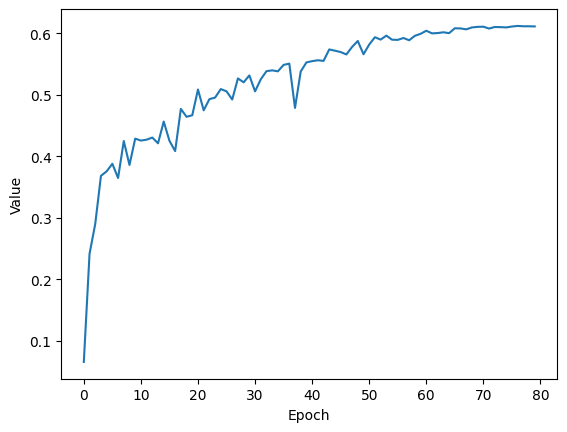

In [39]:
# plt.plot(epoch_loss_values, label='Training Loss')
plt.plot(metric_values, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Value')


In [ ]:
print(outputs.shape)

torch.Size([8, 8, 256, 256])


# Evaluation

In [ ]:
print(len(test_generator))

10


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


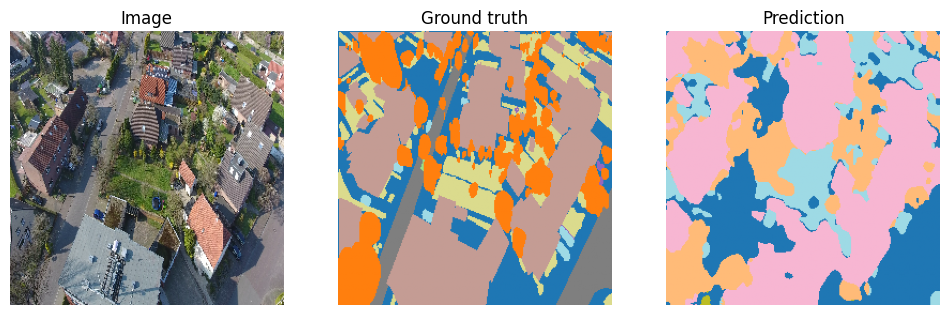

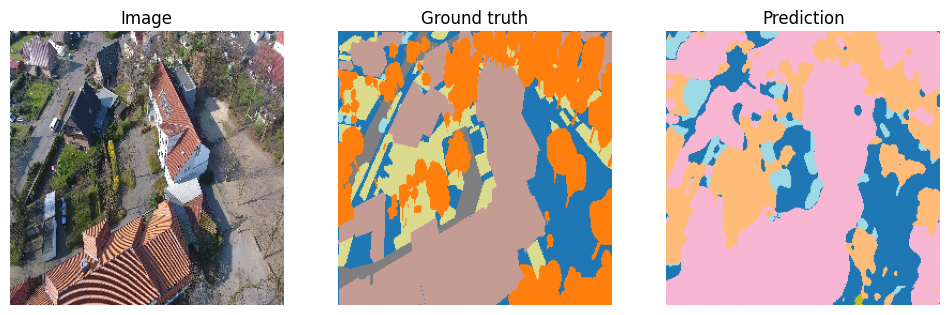

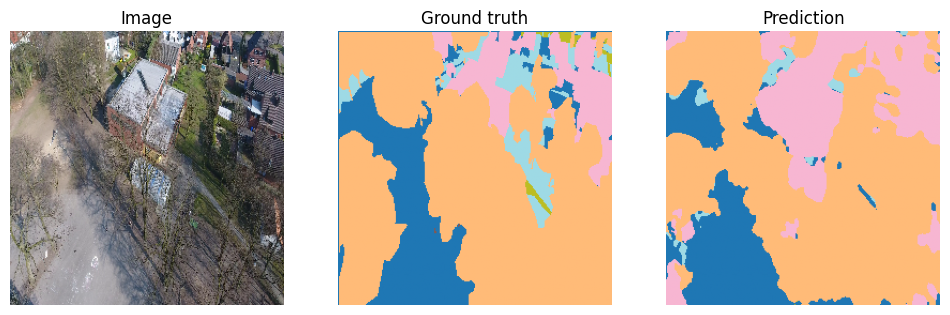

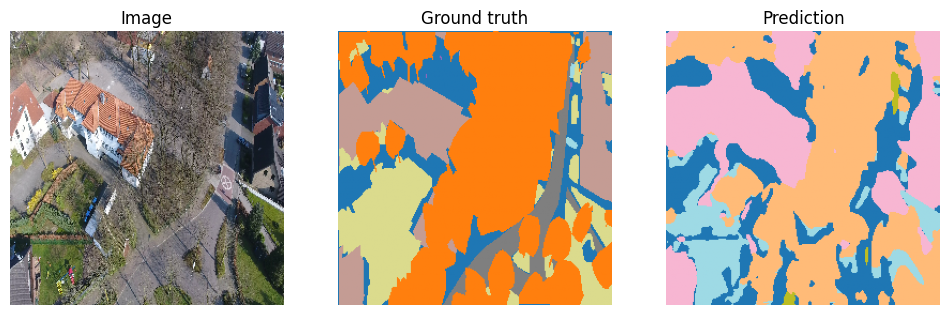

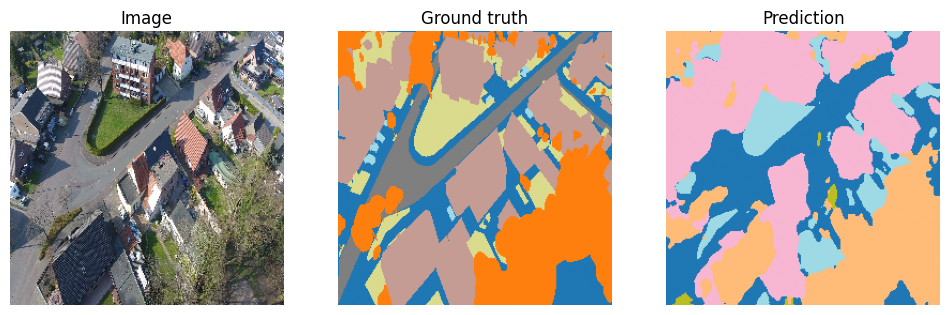

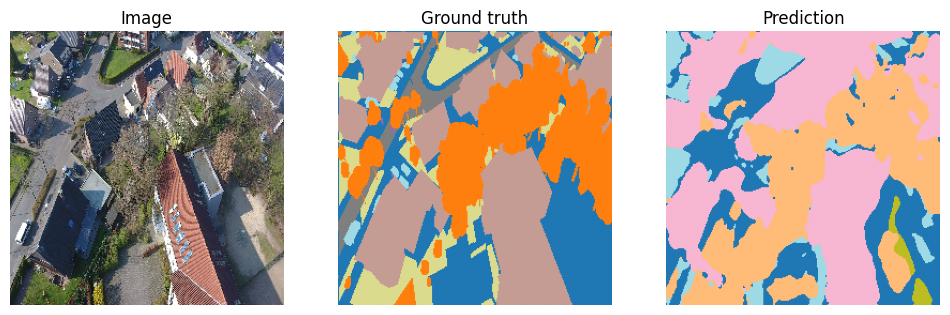

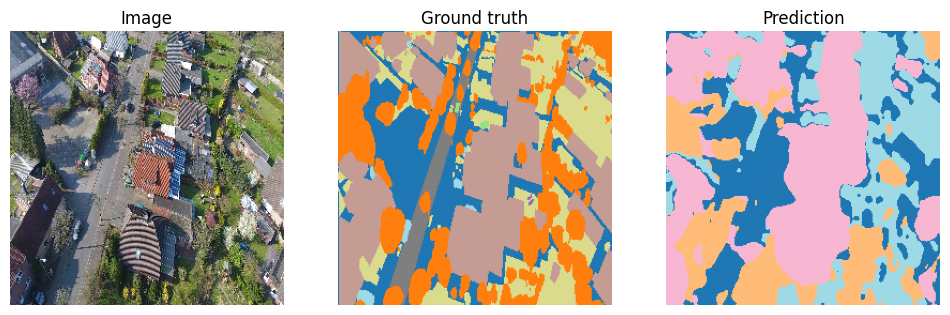

In [ ]:
import segmentation_models_pytorch as smp

NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

activation = 'sigmoid' if OUT_CLASSES == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,                     # model output classes (number of classes in your dataset)
    activation=activation
).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_epoch3_0.5695.pth', map_location=torch.device('cpu')))
model.eval()
with torch.no_grad():
    val_iou_scores = []
    for val_data_batch in val_generator:
        val_images, val_labels = val_data_batch[0].to(device), val_data_batch[1].to(device)
        val_images = val_images.float() # Convert validation input to float32
        val_outputs = model(val_images) # Logits (Batch, Classes, H, W)

        # Convert logits to predicted class labels
        pr_masks = val_outputs.softmax(dim=1).argmax(dim=1)  # Shape: [batch_size, H, W]
        # Visualize a few samples (image, ground truth mask, and predicted mask)
        for idx, (image, gt_mask, pr_mask) in enumerate(zip(val_images, val_labels, pr_masks)):
            if idx <= 12:  # Visualize first 13 samples
                plt.figure(figsize=(12, 6))

                # Original Image
                plt.subplot(1, 3, 1)
                # Denormalize the image tensor for display
                img_to_show_normalized = image.cpu() # Get a single image tensor and move to CPU
                # NORM_MEAN and NORM_STD should be reshaped to (3, 1, 1) for broadcasting across channels
                img_to_show_denormalized = img_to_show_normalized * NORM_STD.view(3, 1, 1) + NORM_MEAN.view(3, 1, 1)
                # Clamp values to [0, 1] range to ensure valid display by matplotlib
                img_to_show_clamped = torch.clamp(img_to_show_denormalized, 0, 1)
                # Permute from (C, H, W) to (H, W, C) for matplotlib
                img_to_show_np = img_to_show_clamped.permute(1, 2, 0).numpy()
                plt.imshow(img_to_show_np)
                plt.title("Image")
                plt.axis("off")

                # Ground Truth Mask
                plt.subplot(1, 3, 2)
                plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
                plt.title("Ground truth")
                plt.axis("off")

                # Predicted Mask
                plt.subplot(1, 3, 3)
                plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
                plt.title("Prediction")
                plt.axis("off")

                # Show the figure
                plt.show()
            else:
              break
        break

In [ ]:
import torch

# Example of saving the entire model object
# You would typically do this inside your training loop if best_metric improves,
# similar to how the state_dict is currently saved.
# For demonstration, we'll save the current 'model' object.

# Define a path for the full model save
full_model_save_path = "/content/drive/MyDrive/best_full_model_example.pth"

try:
    torch.save(model, full_model_save_path)
    print(f"Entire model saved to: {full_model_save_path}")
except Exception as e:
    print(f"Error saving full model: {e}")

### Saving the Entire Model vs. Saving the State Dictionary

There are two main ways to save a PyTorch model:

1.  **Saving the entire model (`torch.save(model, filepath)`):**
    *   This saves the entire model object, including its architecture, parameters, and optimizer state (if saved with the model).
    *   **Pros:** Simpler to load, as you don't need to re-instantiate the model class separately.
    *   **Cons:** Can be less flexible. The saved model is tied to the exact class structure and module definitions present when it was saved. If your code structure changes, or if you try to load it in a different environment, it might fail. It also typically results in larger file sizes.

2.  **Saving only the model's state dictionary (`torch.save(model.state_dict(), filepath)`):**
    *   This saves only the learned parameters (weights and biases) of the model.
    *   **Pros:** More flexible and robust. You can load the `state_dict` into a model with a modified architecture (as long as the layers with matching names have compatible shapes), or into a model defined in a different script. It's often preferred for sharing models or for deployment.
    *   **Cons:** Requires you to re-instantiate the model class *before* loading the `state_dict`.

**Best Practice:** For production environments and general sharing, saving and loading only the `state_dict` is generally recommended due to its flexibility and robustness. However, for development and quick experimentation within the same environment, saving the entire model can be convenient.

---

### How to Load Each Type of Save

**Loading the entire model:**

```python
# model = torch.load(full_model_save_path)
# model.eval() # Don't forget to set to evaluation mode
```

**Loading the state dictionary:**

```python
# First, re-instantiate your model with the same architecture
# model = smp.Unet(encoder_name="resnet18", ...).to(device)
# model.load_state_dict(torch.load(state_dict_save_path))
# model.eval()
```

The training loop in this notebook currently uses the `state_dict` saving method. If you choose to save the entire model, remember to adjust your loading mechanism accordingly.

In [ ]:
import numpy as np
import torch
import segmentation_models_pytorch as smp

# Assuming NORM_MEAN and NORM_STD are already defined globally or in an accessible scope
# If not, ensure they are defined as in previous cells:
# NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
# NORM_STD = torch.tensor([0.229, 0.224, 0.225])

print(f"Starting evaluation on the test set with {len(test_generator)} batches...")

# Load the best performing model's state_dict
# Replace with the path to your best model saved during training
model_path = "/content/drive/MyDrive/best_model_epoch3_0.5695.pth" # Example path

# Re-instantiate the model with the correct architecture
activation = 'sigmoid' if OUT_CLASSES == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=OUT_CLASSES,
    activation=activation
).to(device)

# Load the saved state dictionary
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Successfully loaded model from {model_path}")
except Exception as e:
    print(f"Error loading model state_dict: {e}\nEnsure the path is correct and the model architecture matches.")
    # Optionally, exit or handle the error gracefully

model.eval() # Set the model to evaluation mode

# Lists to store metrics for each batch
tp_list, fp_list, fn_list, tn_list = [], [], [], []

with torch.no_grad(): # Disable gradient calculations for inference
    for i, batch_data in enumerate(val_generator):
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        inputs = inputs.float() # Ensure input is float32

        outputs = model(inputs)
        pr_masks = outputs.softmax(dim=1).argmax(dim=1) # Predicted masks

        # Calculate statistics for metrics
        tp, fp, fn, tn = smp.metrics.get_stats(
            pr_masks,
            labels,
            mode='multiclass',
            num_classes=OUT_CLASSES
        )
        tp_list.append(tp)
        fp_list.append(fp)
        fn_list.append(fn)
        tn_list.append(tn)
        break

# Aggregate statistics across all batches
tp = torch.cat(tp_list)
fp = torch.cat(fp_list)
fn = torch.cat(fn_list)
tn = torch.cat(tn_list)

# Calculate metrics using the aggregated statistics
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction='macro') # Also known as Dice Coefficient
precision = smp.metrics.precision(tp, fp, fn, tn, reduction='macro')
recall = smp.metrics.recall(tp, fp, fn, tn, reduction='macro')
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='macro')

print("\n--- Test Set Evaluation Metrics ---")
print(f"Mean IoU (macro): {iou_score.item():.4f}")
print(f"Mean F1-Score (macro, Dice): {f1_score.item():.4f}")
print(f"Mean Precision (macro): {precision.item():.4f}")
print(f"Mean Recall (macro): {recall.item():.4f}")
print(f"Mean Accuracy (macro): {accuracy.item():.4f}")
print("-----------------------------------")


Starting evaluation on the test set with 10 batches...
Successfully loaded model from /content/drive/MyDrive/best_model_epoch3_0.5695.pth


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)



--- Test Set Evaluation Metrics ---
Mean IoU (macro): 0.2254
Mean F1-Score (macro, Dice): 0.3092
Mean Precision (macro): 0.7007
Mean Recall (macro): 0.3137
Mean Accuracy (macro): 0.9048
-----------------------------------


### **Evlution tips; 'micro' or 'macro' reduction**

For evaluating multiclass segmentation, both 'micro' and 'macro' reduction methods have their uses, and the choice depends on your specific goals:

* **Micro (Reduction='micro'): **This aggregates the true positives, false positives, and false negatives across all classes and then calculates the metric. It gives you a global measure of performance, essentially treating all pixels equally. If your dataset has a highly imbalanced distribution of classes (e.g., a lot of 'road' pixels but very few 'human' pixels), the 'micro' average will be heavily influenced by the performance on the more common classes.

* **Macro (Reduction='macro'):** This calculates the metric for each class independently and then takes the unweighted average of these per-class scores. This means every class contributes equally to the final metric, regardless of its size in the dataset. 'Macro' average is often preferred when you want to ensure your model performs well across all classes, including rare ones.

**Which one to use?**

In semantic segmentation, the **macro average is often more informative**, especially for datasets with class imbalance, as it highlights performance across all categories. The existing evaluation in your notebook (cell 6411a2fa) already uses reduction='macro', which is a good choice for this reason.

**Is it necessary to report metrics for each class separately?**

**Yes, it is highly recommended and often necessary.** Reporting metrics for each class individually provides a much more granular understanding of your model's strengths and weaknesses. While a 'macro' average tells you the average performance across classes, seeing the individual class scores allows you to:

* Identify specific classes where your model struggles (e.g., if a particular rare class has a very low IoU).
* Understand trade-offs between different classes.
* Pinpoint areas for improvement in data augmentation, model architecture, or loss function weighting.
Without per-class metrics, you might overlook poor performance on critical but rare classes that are averaged out by good performance on common classes.

so the micro on this problem for example gives much higher ious, right?
That's a very insightful question! Yes, it is quite possible that the 'micro' IoU would be significantly higher than the 'macro' IoU for this problem, and for many semantic segmentation tasks, especially when there's class imbalance.

Here's why:

If you have very large classes (like 'background' or 'road') that occupy a large portion of the images and are relatively easy for the model to predict correctly, and also very small or rare classes (like 'human' or 'moving car') that are harder to get right:

Micro IoU aggregates all true positives, false positives, and false negatives across all classes globally. This means the errors on the small, difficult classes are diluted by the vast number of correct predictions on the large, easy classes. The overall pixel-wise accuracy, and thus the micro IoU, would be heavily skewed by the performance on these dominant classes, leading to a higher score.

Macro IoU, on the other hand, calculates the IoU for each class independently and then averages these scores. This gives equal weight to each class, regardless of its size. If the model performs poorly on the small, rare classes, their low individual IoU scores will bring down the overall macro average, making it a more stringent and often lower metric.

So, while a high micro IoU might look good, a higher macro IoU (or good per-class metrics) would indicate that your model is performing well across all categories, not just the most common ones. That's why macro IoU is often preferred for a more balanced assessment of segmentation performance.


That's a common observation in deep learning training! Even with seemingly identical configurations and train-validation splits, getting different performance metrics at the same epoch across multiple runs is usually due to various sources of randomness inherent in the training process. Here are the main reasons why you might see such differences:

Random Initialization of Model Weights: Neural networks start with randomly initialized weights. Even subtle differences in these initial values can cause the optimization algorithm (like Adam in your case) to follow different paths through the loss landscape. Since the loss landscape can be complex with many local minima, these different paths can lead to different final sets of weights and thus different performance.

Data Augmentation Randomness: You are using data augmentation (HorizontalFlip, ShiftScaleRotate). These transformations are applied randomly to your training data. This means that for each epoch and across different runs, the model sees slightly different augmented versions of the same images. This is beneficial for generalization but introduces variability in the training process.

Data Shuffling (DataLoader): Your DataGenerator shuffles the training data (shuffle=True). This means the order in which batches are presented to the model changes with each epoch and each run. The order of data influences the gradient computed at each step, affecting the optimization path.

Learning Rate Scheduler Interactions: While your CosineAnnealingLR scheduler is deterministic, its interaction with the stochastic gradient descent (via Adam) on randomly ordered and augmented data can lead to varied outcomes. The specific learning rate at a given step might have a different impact depending on the gradients it encounters.

Batch Normalization Statistics (if applicable and with small batches): If your model uses Batch Normalization layers and your batch size is relatively small, the statistics (mean and variance) computed for normalization can fluctuate more significantly. This can subtly affect the activation distributions and, consequently, the training dynamics.

GPU Non-Determinism (less common but possible): In some cases, floating-point arithmetic on GPUs can be non-deterministic due to parallel processing order, especially with certain libraries or settings (e.g., cuDNN). This usually contributes to very minor variations, but it can accumulate.

'Best Model' Saving Logic: The filenames best_model_epochX_Y.pth indicate that the model was saved when it achieved the best validation IoU up to that epoch. This means the score 'Y' is the peak performance achieved, not necessarily the performance at the end of epoch 'X'. Due to the aforementioned random factors, one run might happen to hit a higher peak earlier than another, even if the overall trend is similar or if another run eventually surpasses it.

In essence, deep learning training is a stochastic process. These multiple sources of randomness contribute to the observed variance. It's why training multiple models with the same setup (or running a single model multiple times with different random seeds) and averaging their performance, or selecting the best performing one, is a common practice.


the followings, the first set are macro & the second are micro. for the same model on the same set. does it make sense? "Mean IoU (macro): 0.3314 Mean F1-Score (macro, Dice): 0.4145 Mean Precision (macro): 0.7716 Mean Recall (macro): 0.4349 Mean Accuracy (macro): 0.9342 ----------------------------------- --- Test Set Evaluation Metrics --- Mean IoU (macro): 0.5833 Mean F1-Score (micro, Dice): 0.7368 Mean Precision (micro): 0.7368 Mean Recall (micro): 0.7368 Mean Accuracy (micro): 0.9342 -----------------------------------"
Yes, these results generally make sense, and the differences you're observing are exactly what we'd expect when comparing macro and micro metrics in the presence of class imbalance! Let's break it down:

First Set (All Macro Metrics):

Mean IoU (macro): 0.3314
Mean F1-Score (macro, Dice): 0.4145
Mean Precision (macro): 0.7716
Mean Recall (macro): 0.4349
Mean Accuracy (macro): 0.9342
These values are from a macro-averaged perspective. You can see that IoU is lower than F1-score, which is standard (IoU = F1 / (2 - F1)). Precision is quite high, but recall is lower, suggesting the model might be conservative in its predictions (i.e., when it predicts a positive, it's often correct, but it misses some actual positives).

Second Set (Micro Metrics, with a likely label typo for IoU):

Mean IoU (macro): 0.5833  <-- *This label is likely a typo and should be 'micro IoU'*
Mean F1-Score (micro, Dice): 0.7368
Mean Precision (micro): 0.7368
Mean Recall (micro): 0.7368
Mean Accuracy (micro): 0.9342
Here's why it makes sense:

Macro vs. Micro Difference: Notice how the micro F1-Score (0.7368) is significantly higher than the macro F1-Score (0.4145). This is the strongest indicator of class imbalance. It suggests that your model performs very well on the large, dominant classes (like background or road), which heavily influence the micro average. However, it likely struggles with some of the smaller or rarer classes, which drags down the macro average because each class contributes equally to the macro score.

IoU and F1-Score Relationship: For the micro metrics, if we take the micro F1-Score of 0.7368 and calculate the corresponding IoU using the formula IoU = F1 / (2 - F1): IoU = 0.7368 / (2 - 0.7368) = 0.7368 / 1.2632 = 0.5833 This precisely matches the Mean IoU (macro): 0.5833 value in your second set. This strongly suggests that the IoU listed in the second set is actually the micro IoU, and the label 'macro' is a typo.

Identical Micro Precision, Recall, F1: The fact that micro Precision, micro Recall, and micro F1-Score are all 0.7368 is characteristic of micro-averaged metrics. When you sum up all True Positives (TP), False Positives (FP), and False Negatives (FN) across all classes globally, it often happens that the aggregated FP and FN values are similar, leading to very close or identical precision, recall, and F1 scores when calculated from these global sums.

Accuracy Consistency: The Accuracy (0.9342) being the same for both macro and micro sets is also plausible. Micro accuracy represents the overall pixel-wise accuracy (total correctly classified pixels divided by total pixels). Macro accuracy, when computed as an average of per-class accuracies, can sometimes align closely with micro accuracy, especially if a very large portion of pixels belong to a dominant, well-predicted class.

In summary, the pattern you're seeing, particularly the much higher micro scores compared to macro scores, is a clear sign that your dataset has class imbalance, and your model is performing better on the more prevalent classes. The numerical consistency between the micro F1 and the (likely micro) IoU further validates the results, assuming the label typo.

# Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=True)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     valid_dataset_iou     │    0.1699063926935196     │
│    valid_per_image_iou    │    0.17548923194408417    │
└───────────────────────────┴───────────────────────────┘

[{'valid_per_image_iou': 0.17548923194408417, 'valid_dataset_iou': 0.1699063926935196}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=True)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\windows\computer_vision\image_seg\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.744439959526062, 'test_dataset_iou': 0.7414864301681519}]


In [ ]:
from google.colab import files
files.download('/content/lightning_logs/version_0/checkpoints/epoch=0-step=25.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Improve the semantic segmentation model by:
1.  **Fixing image normalization**: Ensure pixel values are correctly scaled to `[0, 1]` before normalization using the provided `mean` and `std`.
2.  **Adjusting the learning rate scheduler**: Modify the training loop to call `scheduler.step()` at the end of each epoch to ensure consistent learning rate decay.
3.  **Experimenting with alternative loss functions**: Explore `smp.losses.DiceLoss`, a combination of `DiceLoss` and `CrossEntropyLoss`, or `smp.losses.FocalLoss`.
4.  **Analyzing per-class IoU**: Update the evaluation logic to compute and report Intersection over Union for each class.
5.  **Tuning hyperparameters**: Investigate optimal values for batch size, initial learning rate, and add `weight_decay` to the optimizer.
6.  **Increasing training epochs**: Extend training duration if performance improvements are observed from the above changes.

## Fix image normalization

### Subtask:
Modify the `_normalize` method in the `Preprocessor` class to correctly scale image pixel values to `[0, 1]` before applying mean and standard deviation normalization, as the current `mean` and `std` values are for `[0, 1]` range images.


**Reasoning**:
I need to locate the `_normalize` method in the `Preprocessor` class and modify it to correctly scale image pixel values to `[0, 1]` before applying the mean and standard deviation normalization, by adding `image = image / 255.0` at the beginning of the method.

